In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

2023-04-02 00:52:39.944849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/saeed/anaconda3/envs/aip/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-02 00:52:39.944866: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1


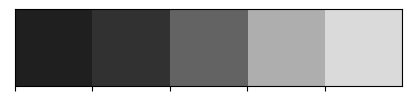

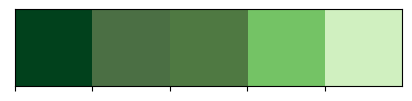

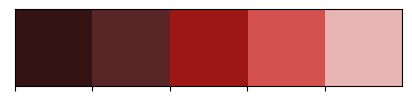

In [5]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [2]:
labels = ['CS', 'ECS', 'FS', 'LS', 'MS']


In [3]:
X_train = []
y_train = []
training_set_path = './data/frames/training'
test_set_path = './data/frames/testing'
image_size = 150
for i in labels:
    folderPath = os.path.join(training_set_path,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(test_set_path,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|█████████████████████████████████████| 1893/1893 [00:31<00:00, 61.04it/s]


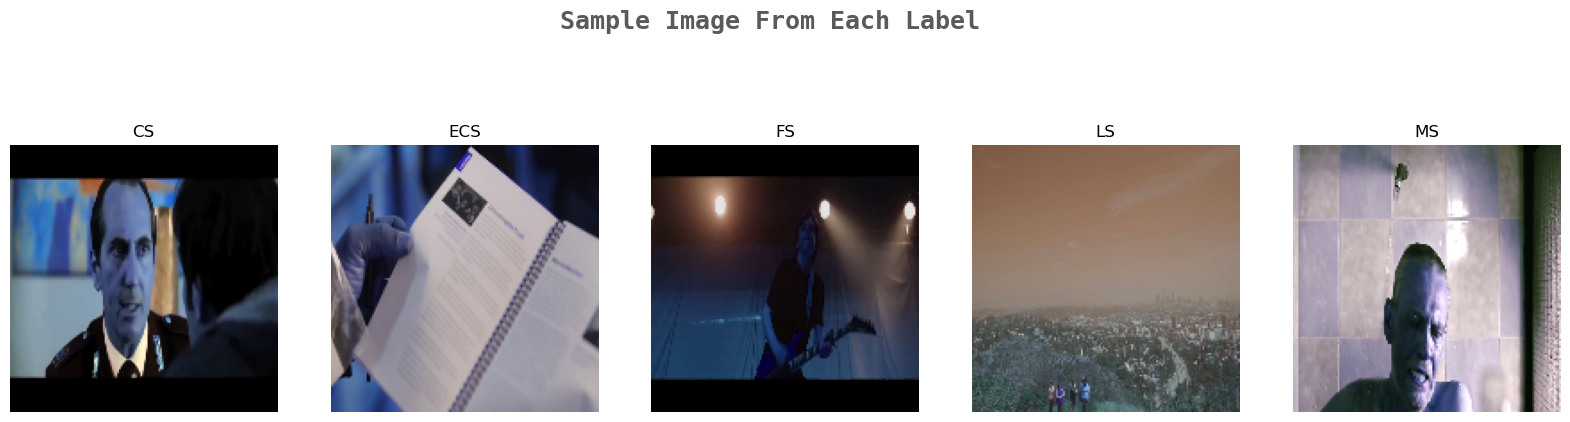

In [6]:
k=0
fig, ax = plt.subplots(1,5,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train.shape

(41777, 150, 150, 3)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))


2023-04-02 01:07:37.242010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-02 01:07:37.243208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/saeed/anaconda3/envs/aip/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-02 01:07:37.243590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/saeed/anaconda3/envs/aip/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-02 01:07:37.243793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasL

In [12]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(5,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [13]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']      

 block2b_expand_conv (Conv2D)   (None, 38, 38, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 38, 38, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 38, 38, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 38, 38, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
          

                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 19, 19, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 19, 19, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 19, 19, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_s

 block4b_activation (Activation  (None, 10, 10, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_s

                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 10, 10, 480)  0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_p

 block5c_project_conv (Conv2D)  (None, 10, 10, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 10, 10, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 10, 10, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 10, 10, 112)  0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block6a_e

 block6b_add (Add)              (None, 5, 5, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 5, 5, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 5, 5, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 5, 5, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block7a_expand_bn (BatchNormal  (None, 5, 5, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 5, 5, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 5, 5, 1152)  10368       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 5, 5, 1152)  4608        ['block7a_dwconv[0][0]']         
 )        

In [14]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [17]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

2023-04-02 01:08:16.472101: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2284132500 exceeds 10% of free system memory.


Epoch 1/12
1058/1058 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.7973
Epoch 1: val_accuracy improved from -inf to 0.82766, saving model to effnet.h5
1058/1058 [==============================] - 1431s 1s/step - loss: 0.5493 - accuracy: 0.7973 - val_loss: 0.4682 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 2/12
1058/1058 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8563
Epoch 2: val_accuracy improved from 0.82766 to 0.84840, saving model to effnet.h5
1058/1058 [==============================] - 1614s 2s/step - loss: 0.3933 - accuracy: 0.8563 - val_loss: 0.4340 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 3/12
1058/1058 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8833
Epoch 3: val_accuracy improved from 0.84840 to 0.85957, saving model to effnet.h5
1058/1058 [==============================] - 1761s 2s/step - loss: 0.3217 - accuracy: 0.8833 - val_loss: 0.4288 - val_accuracy: 0.8596 - lr: 0.0010
Epoch 4/12
1058/105

In [18]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))



131/131 [==============================] - 46s 335ms/step
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       877
           1       0.92      0.84      0.88       846
           2       0.89      0.91      0.90       793
           3       0.89      0.96      0.92       738
           4       0.91      0.85      0.88       924

    accuracy                           0.88      4178
   macro avg       0.89      0.89      0.89      4178
weighted avg       0.89      0.88      0.88      4178



In [19]:
model.save('Trained_12_epoch_tensor.h5')

In [20]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')
        


In [23]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value=(), description='Upload')

In [24]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])